In [1]:
%pip install tensorflow-macos tensorflow-metal opencv-python matplotlib pandas python-mnist numpy Pillow seaborn scikit-learn jupyter ipykernel

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import glob
from sklearn.utils import resample
from PIL import Image
from tensorflow.keras import optimizers
from mnist import MNIST
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("Using gpu: ", gpus)
else:
    print("no gpu found using cpu")

Using gpu:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load dataset

In [4]:
train_dir = "../archive/train/"
test_dir = "../archive/test/"

In [5]:
img_height, img_width = 48,48

In [6]:
label_map = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

In [7]:
def load_dataset(folder):
    images = []
    labels = []
    for label_name, label_idx in label_map.items():
        class_dir = os.path.join(folder, label_name)
        for filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, filename)
            # Load image in grayscale
            img = load_img(img_path, color_mode='grayscale', target_size=(img_height, img_width))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label_idx)
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)
    # Normalize images
    images = images.astype("float32")/255.0
    # Reshape to (num_samples, img_height, img_width, 1) 
    images = images.reshape(-1, img_height, img_width, 1)
    return images, labels

In [8]:
# Load datasets
train_images, train_labels = load_dataset(train_dir)
test_images, test_labels = load_dataset(test_dir)

print("Train:", train_images.shape, train_labels.shape)
print("Test:", test_images.shape, test_labels.shape)

Train: (28709, 48, 48, 1) (28709,)
Test: (7178, 48, 48, 1) (7178,)


# Data Augmentation

In [9]:
""" rotation_layer = layers.RandomRotation(
    factor=0.05,
    fill_mode="constant")
translation_layer = layers.RandomTranslation(
    0.1,0.1,
    fill_mode='constant',
    interpolation='bilinear',
)
zoom_layer = layers.RandomZoom(
    (-0.15,0.15),
    fill_mode='constant',
    interpolation='bilinear'
) """
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1, fill_mode="nearest"),
    layers.RandomTranslation(0.1, 0.1, fill_mode="nearest"),
    layers.RandomZoom(0.1, fill_mode="nearest"),
    layers.RandomContrast(0.1),
])
def augment_image(image, label):
    image = data_augmentation(image, training=True)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label
""" 
def augment_image(image,label):
    #rotation
    image = rotation_layer(image, training=True)
    #translation/shifting
    image = translation_layer(image, training=True)
    #zoom
    image = zoom_layer(image, training=True)

    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label """

2025-10-26 12:57:34.656877: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-10-26 12:57:34.656896: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-26 12:57:34.656899: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-10-26 12:57:34.656914: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-26 12:57:34.656924: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


' \ndef augment_image(image,label):\n    #rotation\n    image = rotation_layer(image, training=True)\n    #translation/shifting\n    image = translation_layer(image, training=True)\n    #zoom\n    image = zoom_layer(image, training=True)\n\n    image = tf.clip_by_value(image, 0.0, 1.0)\n\n    return image, label '

## Dataset for tensorflow

In [10]:
BATCH_SIZE = 32

def make_dataset(image, label, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((image,label))
    if training:
        dataset=dataset.map(augment_image,num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset=dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

def balance_dataset(images, labels):
    """Oversample minority classes to match the largest class"""
    
    # Find the maximum class size
    unique, counts = np.unique(labels, return_counts=True)
    max_count = max(counts)
    
    balanced_images = []
    balanced_labels = []
    
    for class_label in unique:
        # Get all samples for this class
        class_mask = labels == class_label
        class_images = images[class_mask]
        class_labels = labels[class_mask]
        
        # Resample with replacement to match max_count
        resampled_images, resampled_labels = resample(
            class_images,
            class_labels,
            n_samples=max_count,
            random_state=42,
            replace=True
        )
        
        balanced_images.append(resampled_images)
        balanced_labels.append(resampled_labels)
    
    # Concatenate all classes
    balanced_images = np.concatenate(balanced_images)
    balanced_labels = np.concatenate(balanced_labels)
    
    # Shuffle
    indices = np.random.permutation(len(balanced_images))
    balanced_images = balanced_images[indices]
    balanced_labels = balanced_labels[indices]
    
    return balanced_images, balanced_labels

train_images_balanced, train_labels_balanced = balance_dataset(train_images, train_labels)
print("Balanced train:", train_images_balanced.shape, train_labels_balanced.shape)

# Check new distribution
unique, counts = np.unique(train_labels_balanced, return_counts=True)
for label, count in zip(unique, counts):
    emotion = list(label_map.keys())[list(label_map.values()).index(label)]
    print(f"{emotion}: {count}")

# Create dataset with balanced data
train_ds = make_dataset(train_images_balanced, train_labels_balanced, training=True)
test_ds = make_dataset(test_images, test_labels, training=False)

Balanced train: (50505, 48, 48, 1) (50505,)
angry: 7215
disgust: 7215
fear: 7215
happy: 7215
neutral: 7215
sad: 7215
surprise: 7215


## Building the model

In [11]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(48, 48, 1)),

        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(7, activation='softmax')
    ])

    return model


In [12]:
model = create_model()

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model summary

In [14]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,872,583 (22.40 MB)

 Trainable params: 5,869,767 (22.39 MB)

 Non-trainable params: 2,816 (11.00 KB)

## Adding callback

In [15]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
checkpoint = ModelCheckpoint(
    "model.keras",
    monitor="val_loss",
    save_best_only=True
)

## Train

In [16]:
# Calculate class weights based on your data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass Weights:")
for label, weight in class_weight_dict.items():
    emotion = list(label_map.keys())[list(label_map.values()).index(label)]
    print(f"{emotion}: {weight:.2f}")


history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight_dict  
)



Class Weights:
angry: 1.03
disgust: 9.41
fear: 1.00
happy: 0.57
neutral: 0.83
sad: 0.85
surprise: 1.29
Epoch 1/50


2025-10-26 12:57:36.432668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 170s 105ms/step - accuracy: 0.1865 - loss: 4.3373 - val_accuracy: 0.0818 - val_loss: 3.0535
Epoch 2/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 236s 149ms/step - accuracy: 0.2066 - loss: 3.1746 - val_accuracy: 0.1158 - val_loss: 2.7751
Epoch 3/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 259s 163ms/step - accuracy: 0.2297 - loss: 2.8055 - val_accuracy: 0.1597 - val_loss: 2.5702
Epoch 4/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 282s 178ms/step - accuracy: 0.2589 - loss: 2.5211 - val_accuracy: 0.2311 - val_loss: 2.0937
Epoch 5/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 280s 176ms/step - accuracy: 0.2894 - loss: 2.2838 - val_accuracy: 0.3306 - val_loss: 1.8007
Epoch 6/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 282s 178ms/step - accuracy: 0.3138 - loss: 2.1289 - val_accuracy: 0.2685 - val_loss: 2.0722
Epoch 7/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 287s 181ms/step - accuracy: 0.3408 - loss: 1.9709 - val_accuracy: 0.2998 - val_loss: 2.0784
Epoch 8/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 286s 181ms/step - accuracy: 0.3

## Save the model

In [17]:
model.save("../models/model.keras")

## Plot Shit

In [18]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss curves
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_model_performance(model, test_ds):
    """
    Plot confusion matrix and classification report
    """
    # Get predictions
    y_pred = []
    y_true = []
    
    for images, labels in test_ds:
        predictions = model.predict(images, verbose=0)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Define emotion labels for FER2013
    emotion_labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    
    # Calculate and print accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Print classification report
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(7)]))

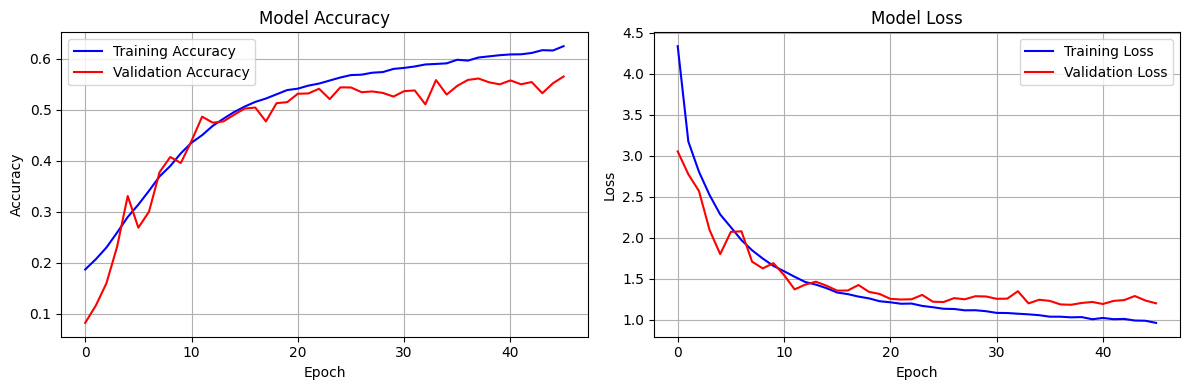

In [19]:
plot_training_history(history)

2025-10-26 16:42:20.013370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


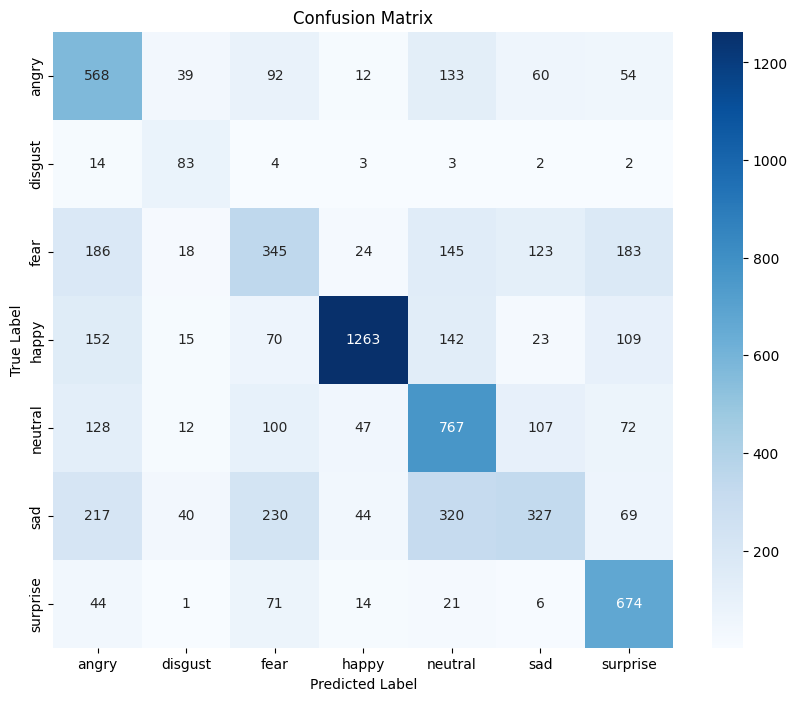

Test Accuracy: 0.5610

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.59      0.50       958
           1       0.40      0.75      0.52       111
           2       0.38      0.34      0.36      1024
           3       0.90      0.71      0.79      1774
           4       0.50      0.62      0.55      1233
           5       0.50      0.26      0.35      1247
           6       0.58      0.81      0.68       831

    accuracy                           0.56      7178
   macro avg       0.53      0.58      0.54      7178
weighted avg       0.58      0.56      0.56      7178



In [20]:
plot_model_performance(model, test_ds)

## Test Shit

In [21]:
def preprocess_image(image_path):
    """
    Preprocess a single image for prediction
    """
    try:
        # Load image
        img = Image.open(image_path)
        
        # Convert to grayscale if needed
        if img.mode != 'L':
            img = img.convert('L')
        
        # Resize to 48x48
        img = img.resize((img_height, img_width))
        
        # Convert to numpy array
        img_array = np.array(img, dtype=np.float32)
        
        # Normalize pixel values to [0, 1]
        img_array = img_array / 255.0
        
        # Reshape to (1, img_height, img_width, 1) for model input
        img_array = img_array.reshape(1, img_height, img_width, 1)
        
        return img_array
        
    except Exception as e:
        print(f"Error processing image {image_path}: {str(e)}")
        return None

def predict_images_from_folder(model, folder_path, num_images=6):
    """
    Predict digit images from a folder and display results
    """
    # Get all image files from folder
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif']
    image_files = []
    
    for extension in image_extensions:
        image_files.extend(glob.glob(os.path.join(folder_path, extension)))
    
    if not image_files:
        print(f"No image files found in {folder_path}")
        return
    
    # Limit to num_images
    image_files = image_files[:num_images]
    
    # Set up the plot
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i, image_path in enumerate(image_files):
        if i >= num_images:
            break
            
        # Preprocess image
        processed_img = preprocess_image(image_path)
        
        if processed_img is not None:
            # Make prediction
            prediction = model.predict(processed_img, verbose=0)
            predicted_digit = np.argmax(prediction[0])
            confidence = np.max(prediction[0])
            
            # Load original image for display
            original_img = Image.open(image_path)
            if original_img.mode != 'L':
                original_img = original_img.convert('L')
            
            # Plot the image
            axes[i].imshow(original_img, cmap='gray')
            axes[i].set_title(f'Predicted: {predicted_digit}\nConfidence: {confidence:.3f}')
            axes[i].axis('off')
            
            print(f"Image: {os.path.basename(image_path)}")
            print(f"Predicted digit: {predicted_digit}")
            print(f"Confidence: {confidence:.3f}")
            print("-" * 30)
        else:
            axes[i].text(0.5, 0.5, 'Error loading\nimage', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

def predict_test_samples(model, test_images, test_labels, num_samples=6):
    """
    Predict some test samples and show results
    """
    # Get random samples
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get the image and true label
        img = test_images[idx]
        true_label = test_labels[idx]
        
        # Make prediction
        prediction = model.predict(img.reshape(1, img_height, img_width, 1), verbose=0)
        predicted_label = np.argmax(prediction[0])
        confidence = np.max(prediction[0])
        
        # Plot
        axes[i].imshow(img.reshape(img_height, img_width), cmap='gray')
        color = 'green' if predicted_label == true_label else 'red'
        axes[i].set_title(f'True: {true_label}, Pred: {predicted_label}\nConf: {confidence:.3f}', 
                         color=color)
        axes[i].axis('off')
    
    plt.suptitle('Test Sample Predictions (Green=Correct, Red=Wrong)')
    plt.tight_layout()
    plt.show()

Image: PrivateTest_14565821.jpg
Predicted digit: 0
Confidence: 0.632
------------------------------
Image: PublicTest_65465298.jpg
Predicted digit: 6
Confidence: 0.515
------------------------------
Image: PublicTest_93558553.jpg
Predicted digit: 2
Confidence: 0.394
------------------------------
Image: PublicTest_28963544.jpg
Predicted digit: 4
Confidence: 0.424
------------------------------
Image: PublicTest_90347378.jpg
Predicted digit: 4
Confidence: 0.790
------------------------------
Image: PrivateTest_3309033.jpg
Predicted digit: 1
Confidence: 0.981
------------------------------


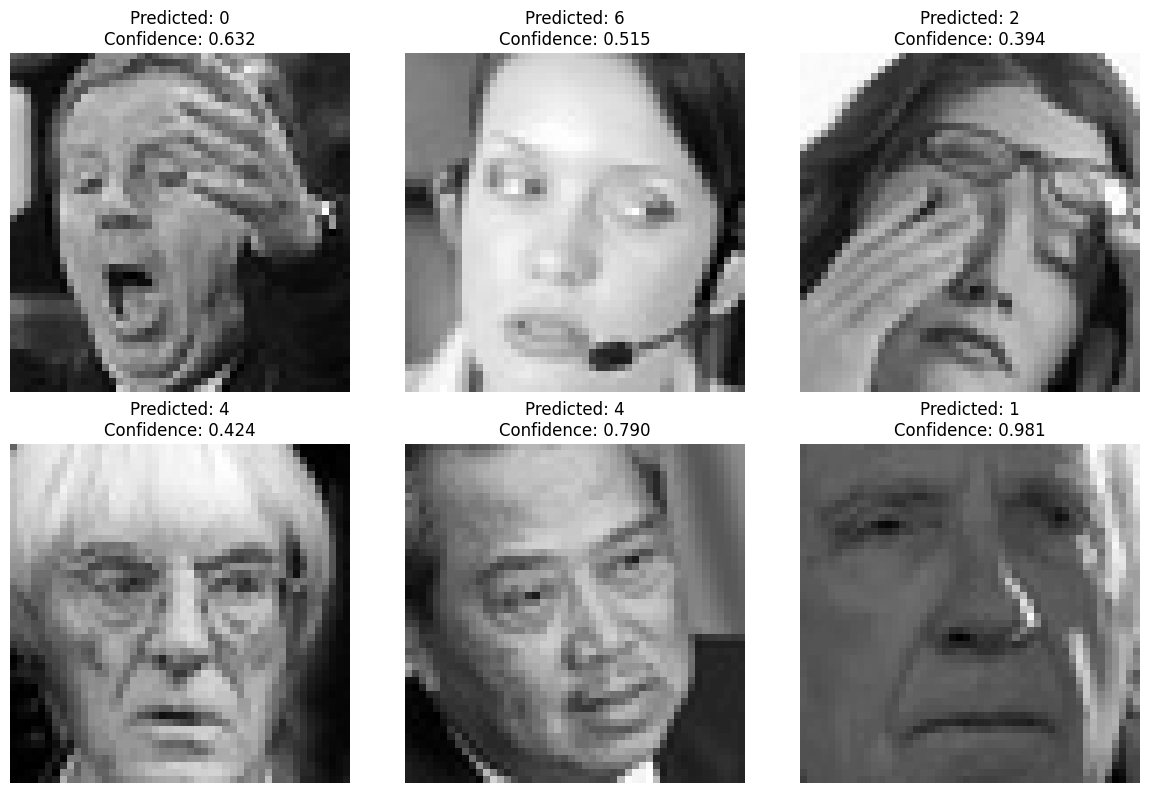

Image: PublicTest_31237465.jpg
Predicted digit: 1
Confidence: 0.913
------------------------------
Image: PublicTest_83844004.jpg
Predicted digit: 1
Confidence: 0.978
------------------------------
Image: PublicTest_15595284.jpg
Predicted digit: 4
Confidence: 0.591
------------------------------
Image: PublicTest_85498443.jpg
Predicted digit: 3
Confidence: 0.653
------------------------------
Image: PrivateTest_91247555.jpg
Predicted digit: 1
Confidence: 0.586
------------------------------
Image: PublicTest_43293519.jpg
Predicted digit: 1
Confidence: 1.000
------------------------------


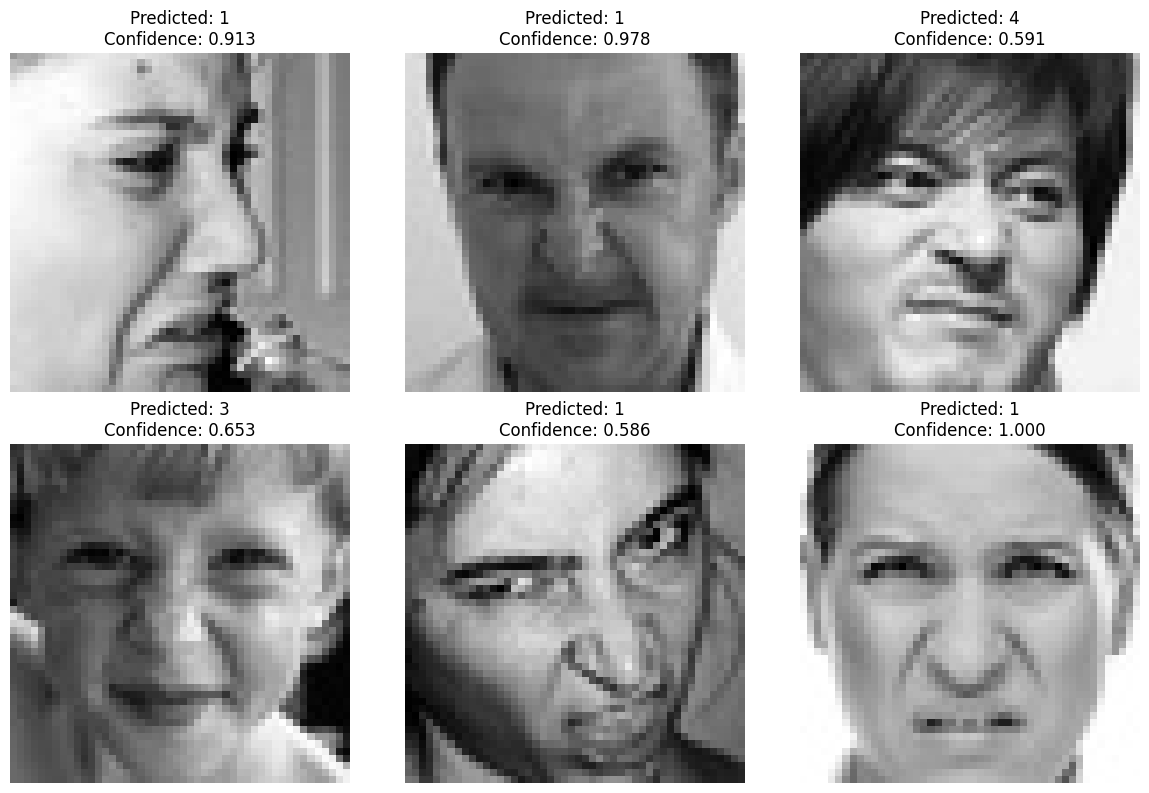

Image: PrivateTest_50722719.jpg
Predicted digit: 6
Confidence: 0.488
------------------------------
Image: PublicTest_16937676.jpg
Predicted digit: 0
Confidence: 0.600
------------------------------
Image: PrivateTest_37810242.jpg
Predicted digit: 5
Confidence: 0.414
------------------------------
Image: PrivateTest_75734102.jpg
Predicted digit: 2
Confidence: 0.901
------------------------------
Image: PrivateTest_47221428.jpg
Predicted digit: 6
Confidence: 0.948
------------------------------
Image: PrivateTest_69905912.jpg
Predicted digit: 2
Confidence: 0.696
------------------------------


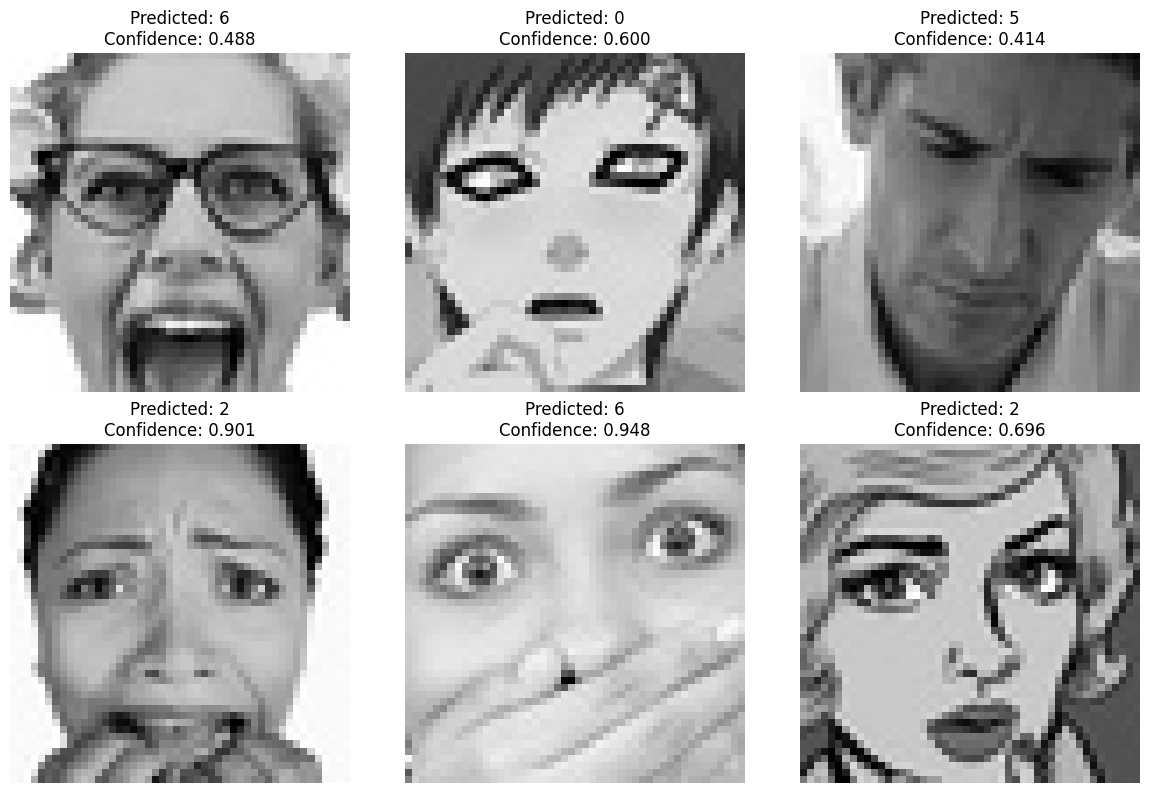

Image: PrivateTest_45699463.jpg
Predicted digit: 3
Confidence: 0.961
------------------------------
Image: PrivateTest_61855708.jpg
Predicted digit: 6
Confidence: 0.338
------------------------------
Image: PublicTest_53681781.jpg
Predicted digit: 3
Confidence: 0.791
------------------------------
Image: PrivateTest_52109800.jpg
Predicted digit: 0
Confidence: 0.767
------------------------------
Image: PublicTest_41104919.jpg
Predicted digit: 3
Confidence: 0.926
------------------------------
Image: PrivateTest_16487993.jpg
Predicted digit: 3
Confidence: 0.424
------------------------------


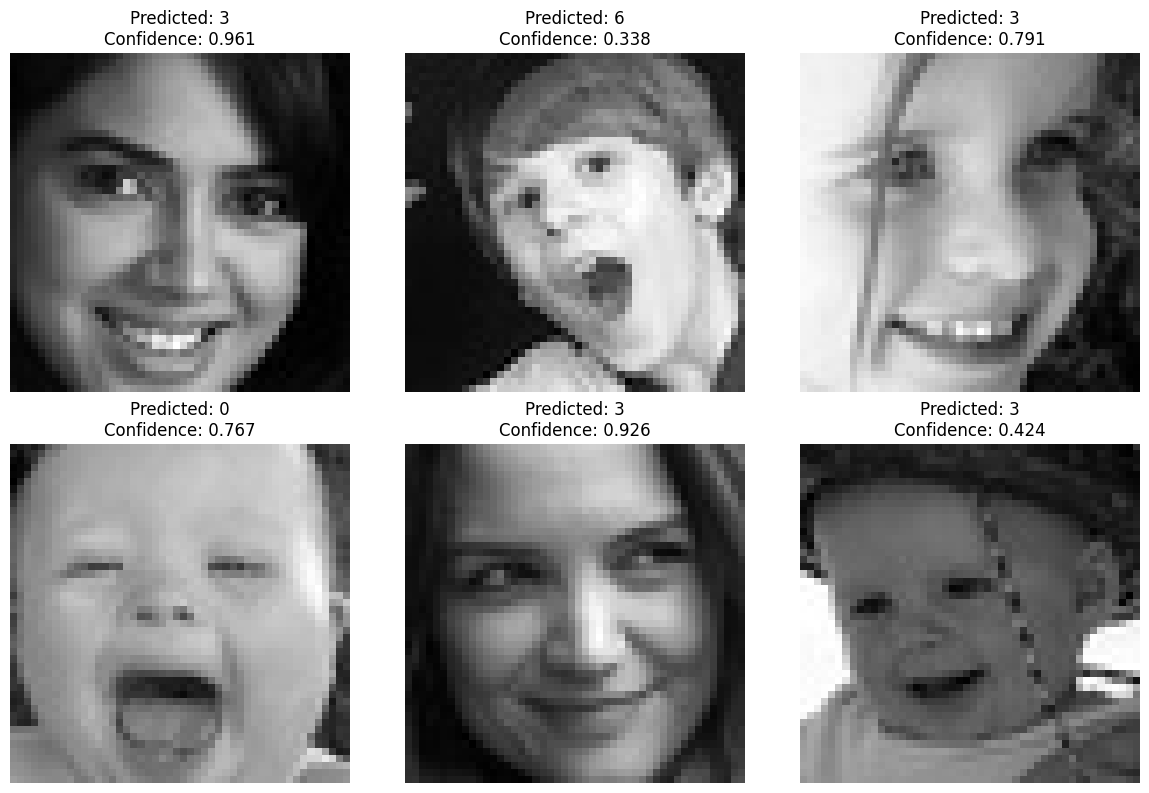

Image: PublicTest_89519100.jpg
Predicted digit: 4
Confidence: 0.685
------------------------------
Image: PublicTest_57151026.jpg
Predicted digit: 5
Confidence: 0.572
------------------------------
Image: PublicTest_87228416.jpg
Predicted digit: 4
Confidence: 0.717
------------------------------
Image: PrivateTest_8942747.jpg
Predicted digit: 1
Confidence: 0.427
------------------------------
Image: PublicTest_40027557.jpg
Predicted digit: 2
Confidence: 0.389
------------------------------
Image: PublicTest_16168281.jpg
Predicted digit: 3
Confidence: 0.415
------------------------------


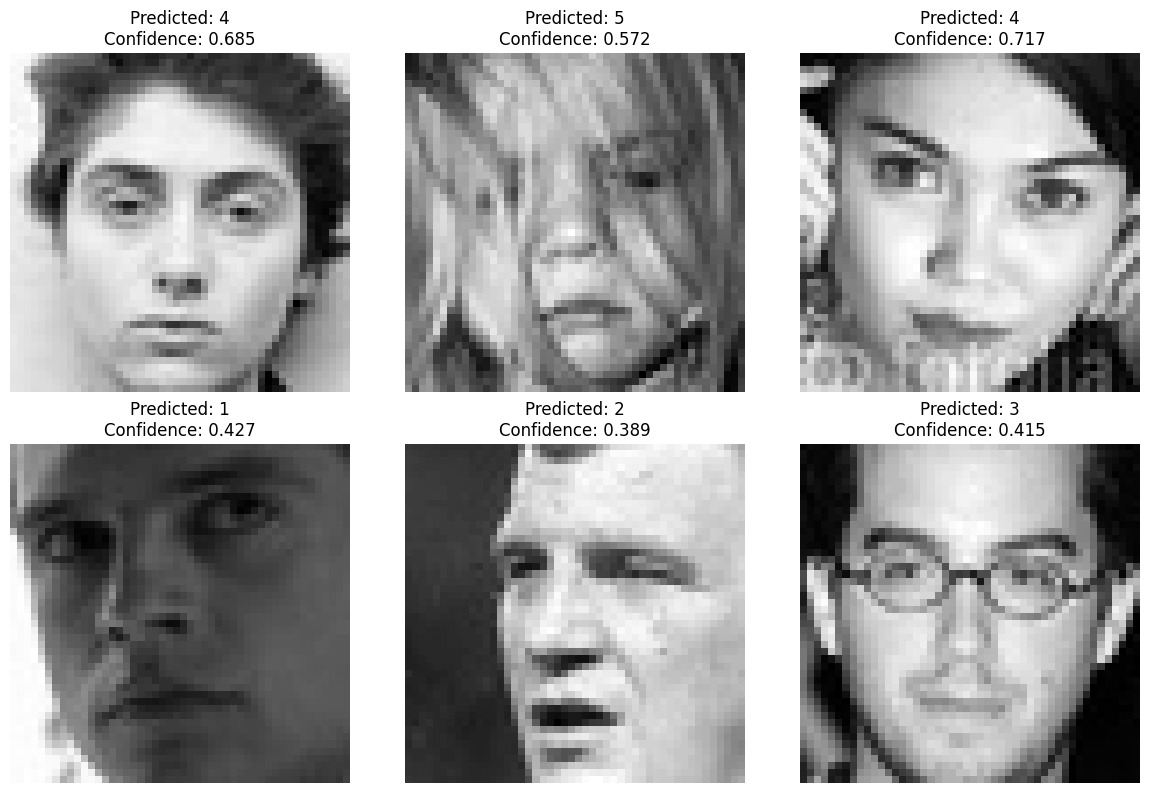

Image: PublicTest_91585163.jpg
Predicted digit: 5
Confidence: 0.398
------------------------------
Image: PrivateTest_79985549.jpg
Predicted digit: 4
Confidence: 0.809
------------------------------
Image: PublicTest_68003302.jpg
Predicted digit: 0
Confidence: 0.492
------------------------------
Image: PublicTest_29660027.jpg
Predicted digit: 2
Confidence: 0.406
------------------------------
Image: PublicTest_48078671.jpg
Predicted digit: 4
Confidence: 0.389
------------------------------
Image: PublicTest_29746792.jpg
Predicted digit: 4
Confidence: 0.468
------------------------------


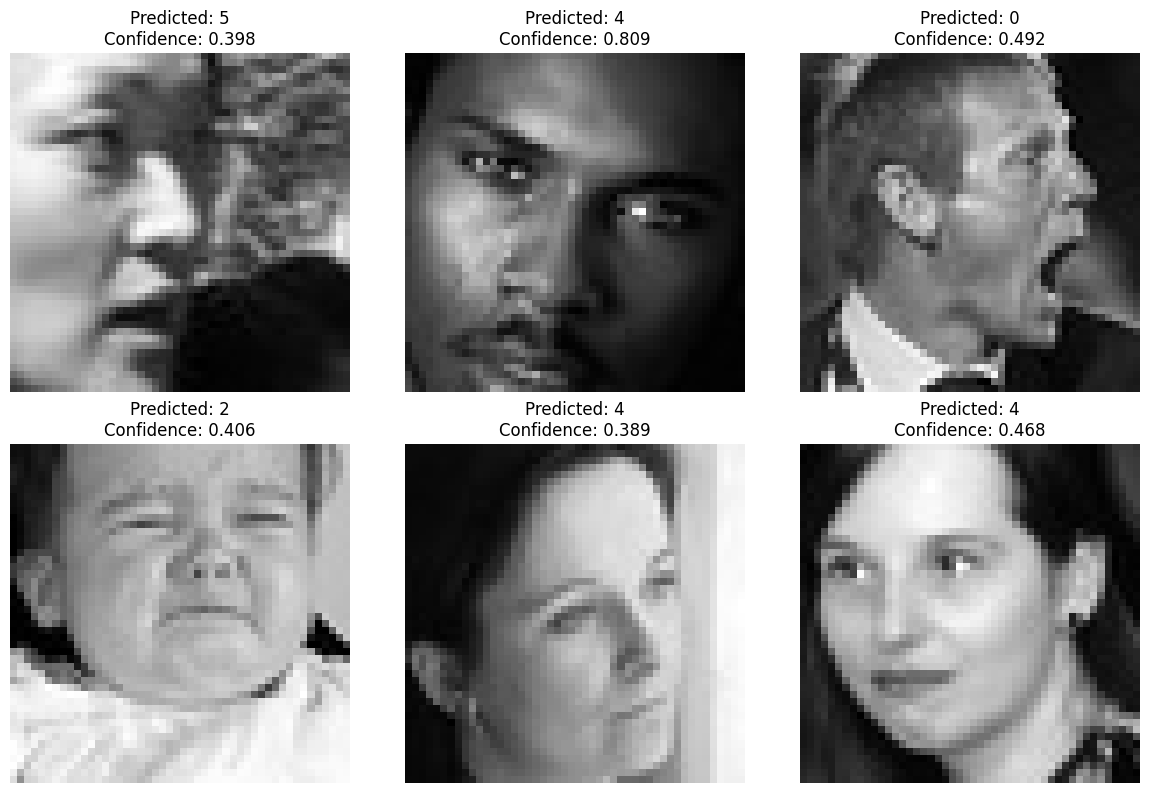

Image: PrivateTest_17898849.jpg
Predicted digit: 6
Confidence: 0.513
------------------------------
Image: PrivateTest_91967730.jpg
Predicted digit: 0
Confidence: 0.887
------------------------------
Image: PrivateTest_41450476.jpg
Predicted digit: 6
Confidence: 0.974
------------------------------
Image: PrivateTest_99502303.jpg
Predicted digit: 6
Confidence: 0.746
------------------------------
Image: PublicTest_38966726.jpg
Predicted digit: 6
Confidence: 0.964
------------------------------
Image: PublicTest_44720580.jpg
Predicted digit: 6
Confidence: 0.821
------------------------------


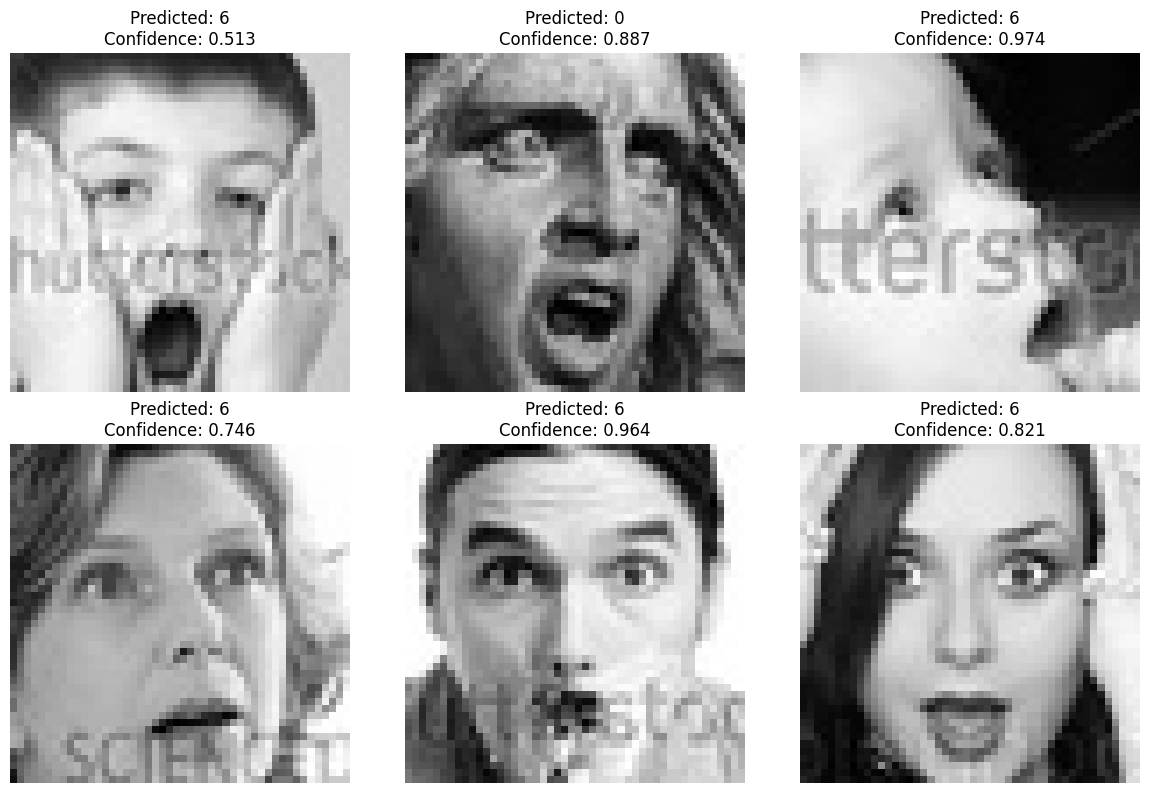

In [24]:
predict_images_from_folder(model, "../archive/test/angry")
predict_images_from_folder(model, "../archive/test/disgust")
predict_images_from_folder(model, "../archive/test/fear")
predict_images_from_folder(model, "../archive/test/happy")
predict_images_from_folder(model, "../archive/test/neutral")
predict_images_from_folder(model, "../archive/test/sad")
predict_images_from_folder(model, "../archive/test/surprise")